# Part 2: Generalization across subjects

In [27]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io import loadmat
from pathlib import Path


In [28]:
DATA_DIR = Path("data")   # root folder
N_SUBJECTS = 27

### 1.

In [29]:
all_emg = {}
all_stimulus = {}
all_repetition = {}

for subj in range(1, N_SUBJECTS + 1):
    # Correct path: data/sX/sX_A1_E1.mat
    file_path = DATA_DIR / f"s{subj}" / f"s{subj}_A1_E1.mat"
    
    print(f"Loading subject {subj}: {file_path}")

    data = loadmat(file_path)

    emg = data["emg"]
    stimulus = data["restimulus"].squeeze()
    repetition = data["rerepetition"].squeeze()

    all_emg[subj] = emg
    all_stimulus[subj] = stimulus
    all_repetition[subj] = repetition

Loading subject 1: data/s1/s1_A1_E1.mat
Loading subject 2: data/s2/s2_A1_E1.mat
Loading subject 3: data/s3/s3_A1_E1.mat
Loading subject 4: data/s4/s4_A1_E1.mat
Loading subject 5: data/s5/s5_A1_E1.mat
Loading subject 6: data/s6/s6_A1_E1.mat
Loading subject 7: data/s7/s7_A1_E1.mat
Loading subject 8: data/s8/s8_A1_E1.mat
Loading subject 9: data/s9/s9_A1_E1.mat
Loading subject 10: data/s10/s10_A1_E1.mat
Loading subject 11: data/s11/s11_A1_E1.mat
Loading subject 12: data/s12/s12_A1_E1.mat
Loading subject 13: data/s13/s13_A1_E1.mat
Loading subject 14: data/s14/s14_A1_E1.mat
Loading subject 15: data/s15/s15_A1_E1.mat
Loading subject 16: data/s16/s16_A1_E1.mat
Loading subject 17: data/s17/s17_A1_E1.mat
Loading subject 18: data/s18/s18_A1_E1.mat
Loading subject 19: data/s19/s19_A1_E1.mat
Loading subject 20: data/s20/s20_A1_E1.mat
Loading subject 21: data/s21/s21_A1_E1.mat
Loading subject 22: data/s22/s22_A1_E1.mat
Loading subject 23: data/s23/s23_A1_E1.mat
Loading subject 24: data/s24/s24_A1_E1

### 2. Feature extraction

In [30]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [31]:
mav  = lambda x: np.mean(np.abs(x), axis=0)
std  = lambda x: np.std(x, axis=0)
maxav = lambda x: np.max(np.abs(x), axis=0)
rms  = lambda x: np.sqrt(np.mean(x**2, axis=0))
wl   = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

def ssc(x, eps=1e-6):
    diff1 = x[1:-1, :] - x[:-2, :]
    diff2 = x[1:-1, :] - x[2:, :]
    return np.sum((diff1 * diff2 < -eps).astype(int), axis=0)

features = [mav, std, maxav, rms, wl, ssc]

In [32]:
all_datasets = {}   # subj → feature matrix (n_trials, n_features)
all_labels = {}     # subj → labels (n_trials,)

for subj in range(1, N_SUBJECTS + 1):
    print(f"\nBuilding dataset for subject {subj}")

    emg = all_emg[subj]
    stimulus = all_stimulus[subj]
    repetition = all_repetition[subj]

    X_subj, y_subj = build_dataset_from_ninapro(
        emg=emg,
        stimulus=stimulus,
        repetition=repetition,
        features=features,
    )

    print(f"  X_subj shape: {X_subj.shape}, y_subj shape: {y_subj.shape}")

    all_datasets[subj] = X_subj
    all_labels[subj] = y_subj



Building dataset for subject 1
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 2
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 3
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 4
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 5
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 6
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 7
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 8
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 9
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 10
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 11
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 12
  X_subj shape: (120, 60), y_subj shape: (120,)

Building dataset for subject 13
  X_

In [33]:
feature_types = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC"]
n_channels = 10
n_feat_per_channel = len(feature_types)

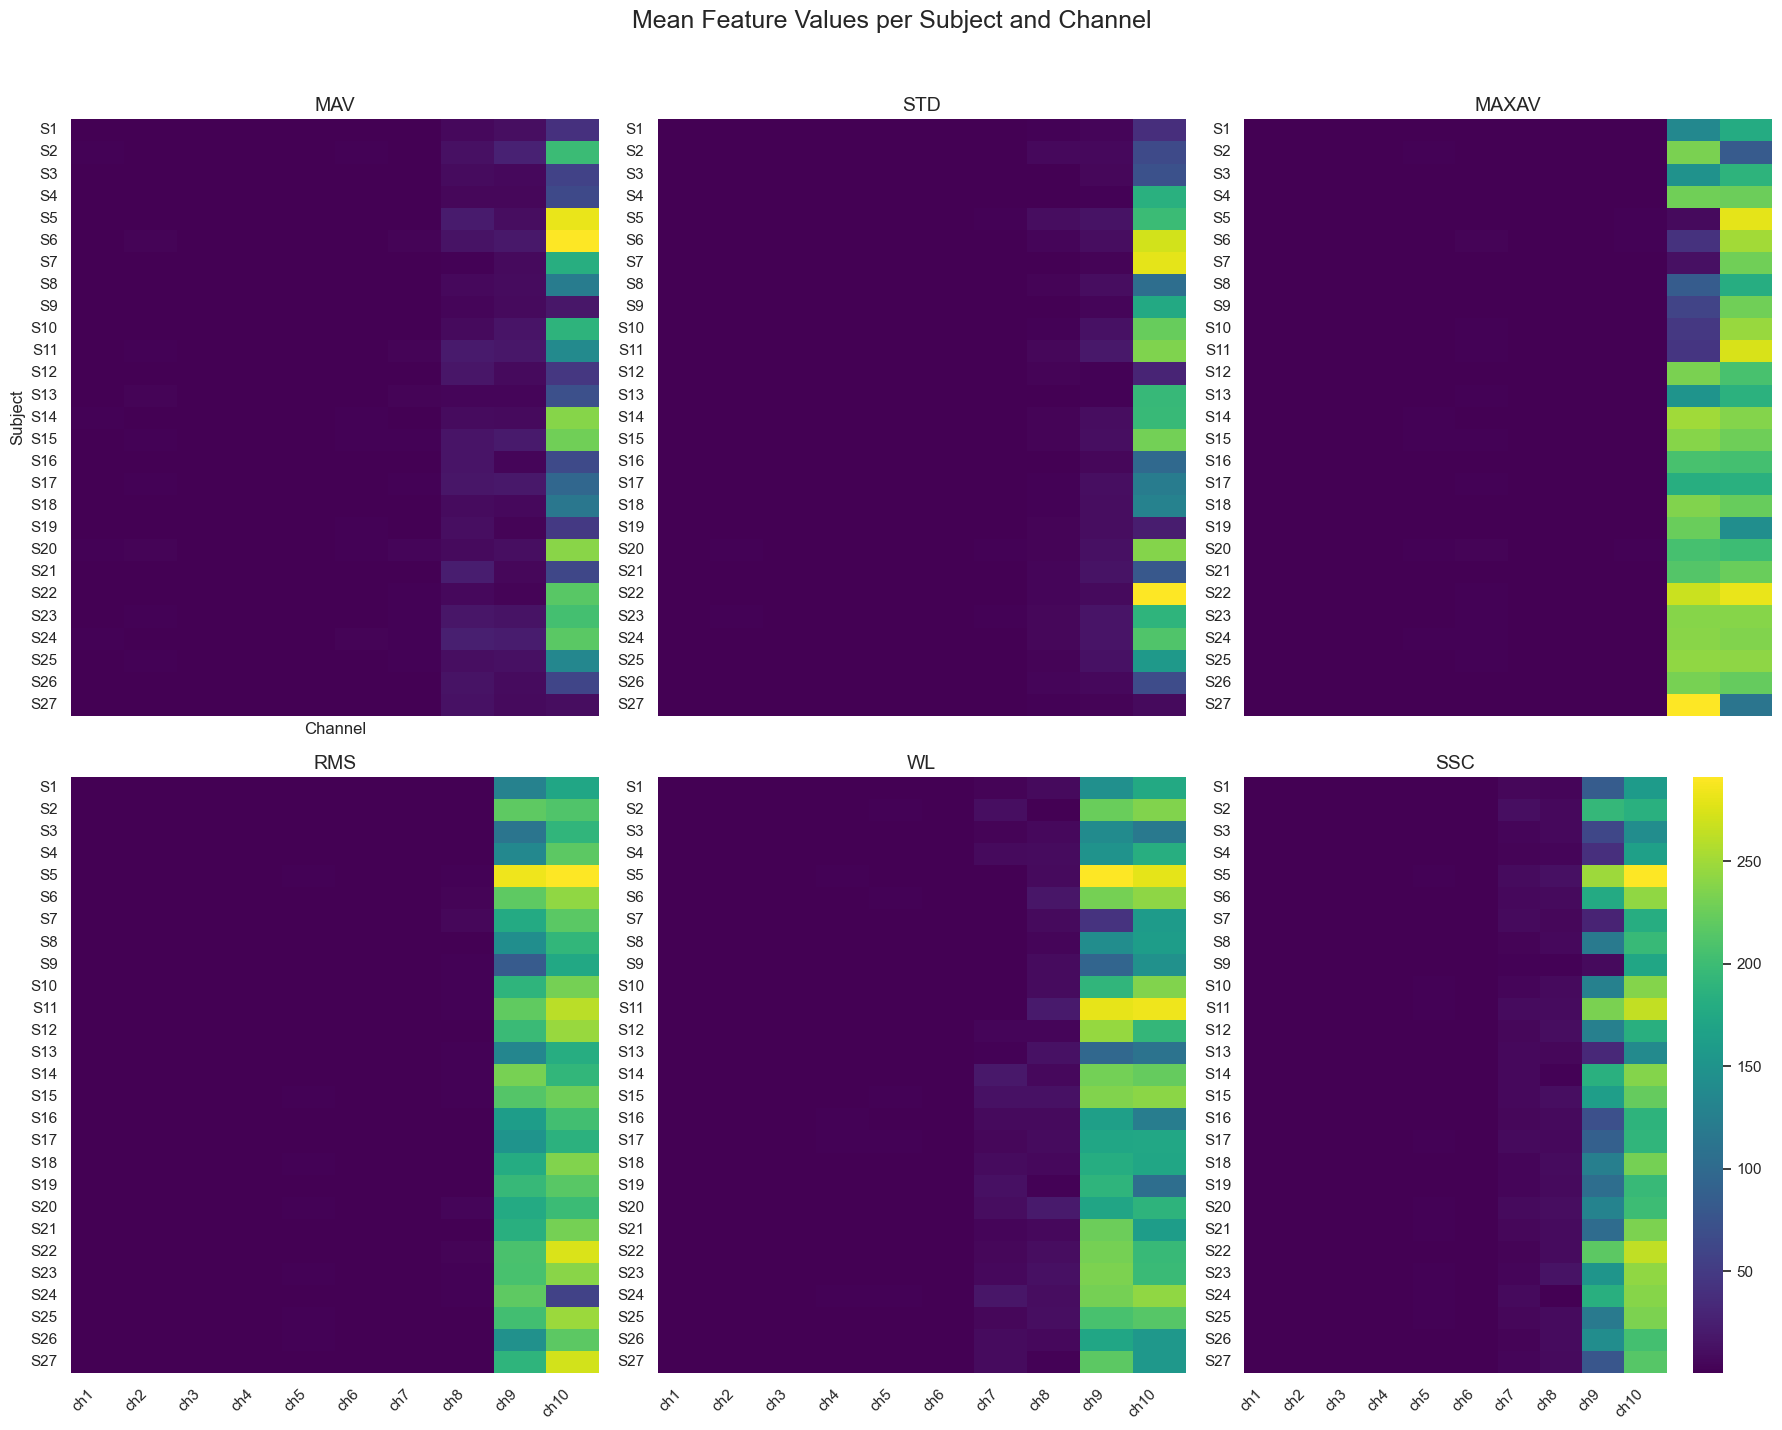

In [34]:
sns.set()

n_feat_types = len(feature_types)

# means[f_idx, subj-1, ch] = mean value of that feature for that subject & channel
means = np.zeros((n_feat_types, N_SUBJECTS, n_channels))

for f_idx, ftype in enumerate(feature_types):
    for subj in range(1, N_SUBJECTS + 1):
        Xs = all_datasets[subj]  # (n_trials_subj, n_features)

        for ch in range(n_channels):
            # index of this (channel, feature_type) in the flattened features
            global_idx = ch * n_feat_per_channel + f_idx
            vals = Xs[:, global_idx]
            means[f_idx, subj-1, ch] = vals.mean()


fig, axes = plt.subplots(2, 3, figsize=(18, 14), sharex=True)  
axes = axes.ravel()

for f_idx, ftype in enumerate(feature_types):
    ax = axes[f_idx]

    sns.heatmap(
        means[f_idx],
        ax=ax,
        cmap="viridis",
        cbar=f_idx == len(feature_types) - 1,  # only last subplot has a colorbar
        xticklabels=[f"ch{c+1}" for c in range(n_channels)],
        yticklabels=[f"S{subj}" for subj in range(1, N_SUBJECTS + 1)]
    )

    ax.set_title(ftype, fontsize=14)

    # Remove axis labels from all but ONE subplot
    if f_idx != 0:
        ax.set_ylabel("")
        ax.set_xlabel("")
    else:
        ax.set_ylabel("Subject", fontsize=12)
        ax.set_xlabel("Channel", fontsize=12)

    # Rotate x tick labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.suptitle("Mean Feature Values per Subject and Channel", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


### 3. 

In [36]:
test_subj = 5

# Test data = subject 5
X_test = all_datasets[test_subj]
y_test = all_labels[test_subj]

# Train data = all subjects except 5
X_train = np.vstack([
    all_datasets[subj]
    for subj in range(1, N_SUBJECTS + 1)
    if subj != test_subj
])
y_train = np.concatenate([
    all_labels[subj]
    for subj in range(1, N_SUBJECTS + 1)
    if subj != test_subj
])

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# Scale using only training subjects
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z  = scaler.transform(X_test)

# Use best GB hyperparameters from Part 1 
clf_cross = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    subsample=0.6,
    random_state=0,
)

clf_cross.fit(X_train_z, y_train)
y_pred_cross = clf_cross.predict(X_test_z)

acc_cross = accuracy_score(y_test, y_pred_cross)
print(f"\nAccuracy when training on 26 subjects and testing on Subject {test_subj}: {acc_cross:.3f}")


Train shape: (3120, 60)
Test shape : (120, 60)

Accuracy when training on 26 subjects and testing on Subject 5: 0.408
